In [12]:
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix  
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import validation_curve, learning_curve, train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans  
from sklearn.mixture import GaussianMixture
from scipy import stats
import matplotlib as mpl
import itertools
from scipy import linalg
from sklearn import mixture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import decomposition
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import sklearn.metrics as metrics
import pandas as pd
from sklearn import preprocessing
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import warnings; warnings.simplefilter('ignore')


## Data Selection
df = pd.read_excel('CTG.xls', 'Raw Data', index_col=None, skiprows=[1,2128,2129,2130])

## Data Preprocessing
#%matplotlib inline
#plt.rcParams["figure.figsize"] = [20,10]
#fig, axes = plt.subplots(nrows=1, ncols=2)
classNames = ['A', 'B', 'C', 'D', 'SH', 'AD', 'DE', 'LD', 'FS', 'SUSP'] 
#correlation_graph(df, axes[0])
#df['NSP'].apply(number_to_class).value_counts().plot(kind='bar', ax=axes[1], rot=0)
#plt.show()

one_hot_enc = LabelBinarizer()
one_hot_encoded_tendency = one_hot_enc.fit_transform(df.Tendency.values)
dfOneHot = pd.DataFrame(
    one_hot_encoded_tendency, 
    columns = ["Tendency"+str(int(i)) for i in range(one_hot_encoded_tendency.shape[1])]
)
df = pd.concat([df, dfOneHot], axis=1)
df = df.drop(['Tendency'], axis=1)
irrelevant_columns = ['Date', 'FileName', 'SegFile']
df.drop(irrelevant_columns, inplace=True, axis=1)
class_columns = ['A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS'] 
y_class = df['CLASS']  
df.drop(class_columns, inplace=True, axis=1)

#print(df.columns.values)

#df['b', 'e','LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean' ,'Median', 'Variance', 'Tendency0', 'Tendency1', 'Tendency2', 'CLASS'].to_csv("CTG_cleaned.csv", sep=',')

## Data Transformation
X = df.drop(['NSP'], axis=1)  
y = df['NSP']  
data_scaled = pd.DataFrame(preprocessing.scale(df), columns = df.columns)
data_scaled = data_scaled.drop(['NSP'], axis=1)

scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X)
# Now apply the transformations to the data:
X = scaler.transform(X)

# EM Model selection using BCA

Best model is full 7


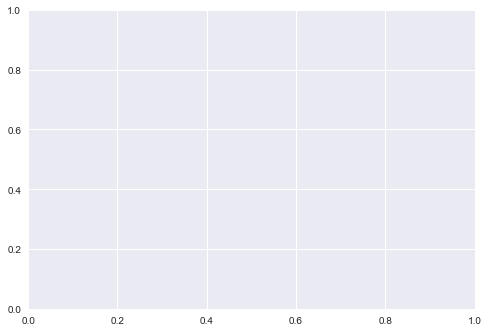

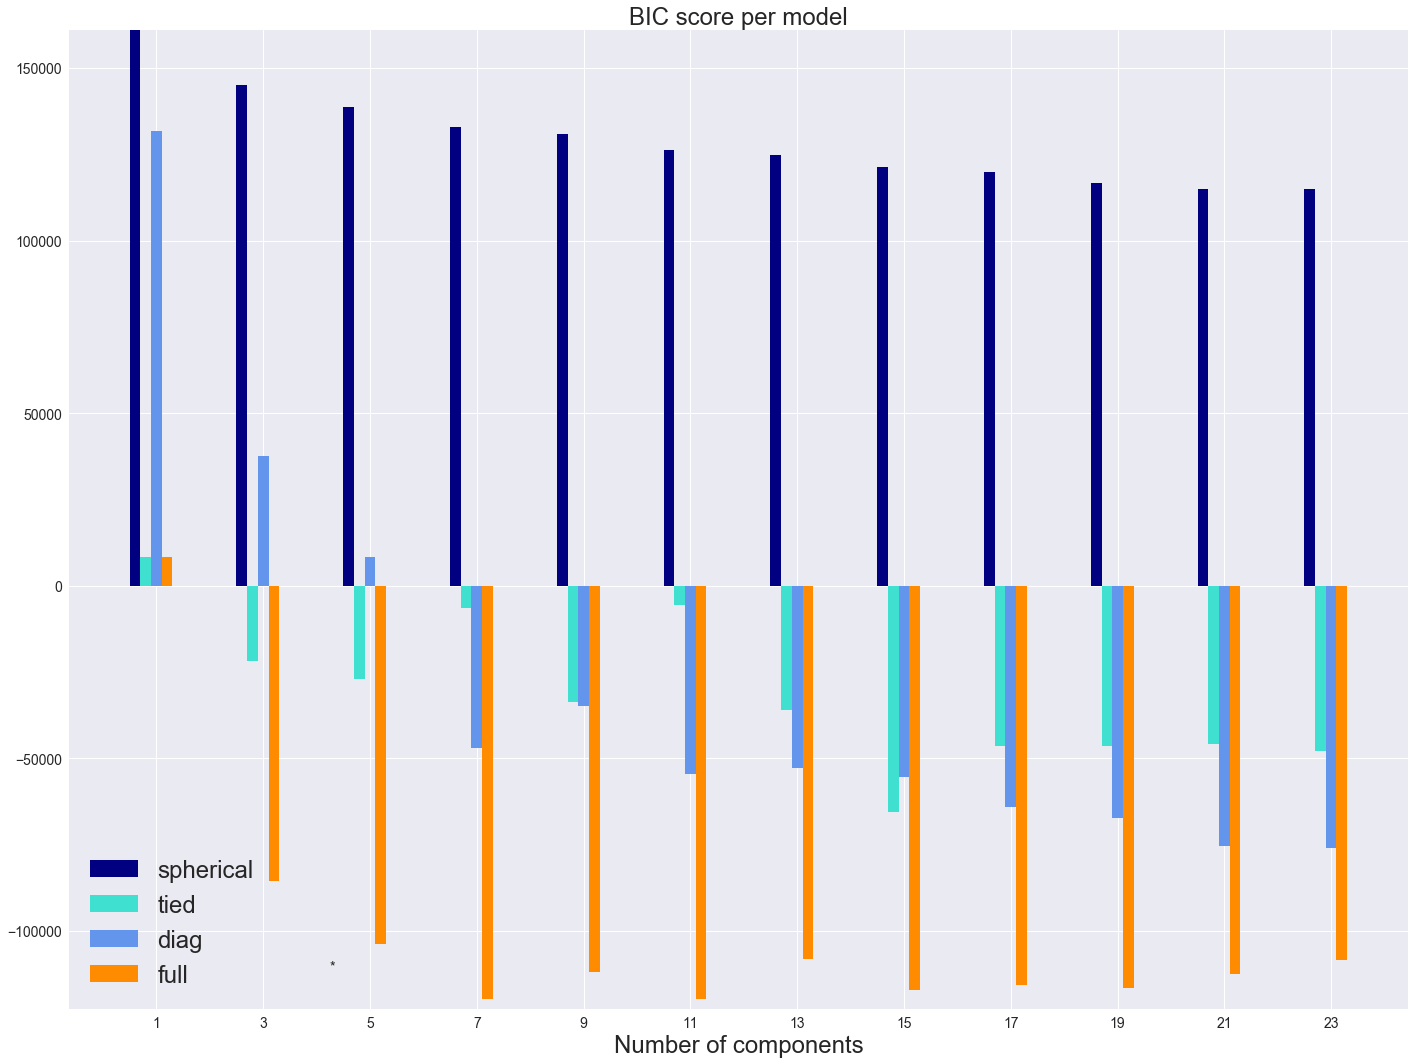

In [72]:
# Generate random sample, two components
np.random.seed(0)
C = y

lowest_bic = np.infty
best_n_components = 0
best_cv_type = 0
bic = []
n_components_range = range(1, 25, 2)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            best_n_components = n_components
            best_cv_type = cv_type

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
print("Best model is", best_cv_type, best_n_components)
bars = []

# Plot the BIC scores
plt.figure(figsize=(24, 18))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model', fontsize=24)
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components', fontsize=24)
spl.legend([b[0] for b in bars], cv_types, fontsize=24)
plt.show()

# Explained Variance of the PCA model

In [ ]:
pca = decomposition.PCA(n_components=23).fit(data_scaled)

print(len(pca.explained_variance_ratio_), len(X[0]))
#print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

plt.xlabel("Principal component")
#plt.bar(range(1,24), pca.explained_variance_ratio_.cumsum())
plt.semilogy(pca.explained_variance_ratio_, '--o', label='explained variance ratio');
plt.semilogy(pca.explained_variance_ratio_.cumsum(), '--o', label='cumulative explained variance ratio');
plt.legend()
plt.show()

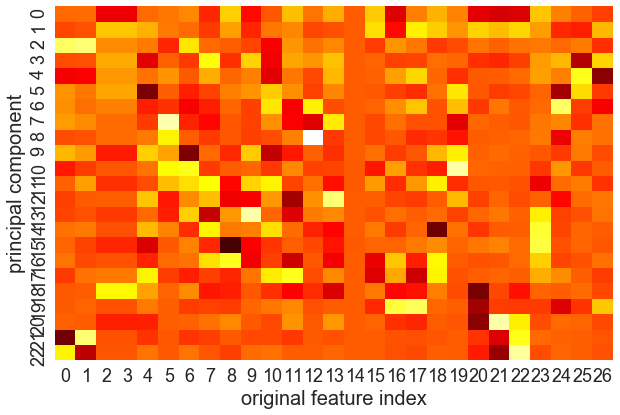

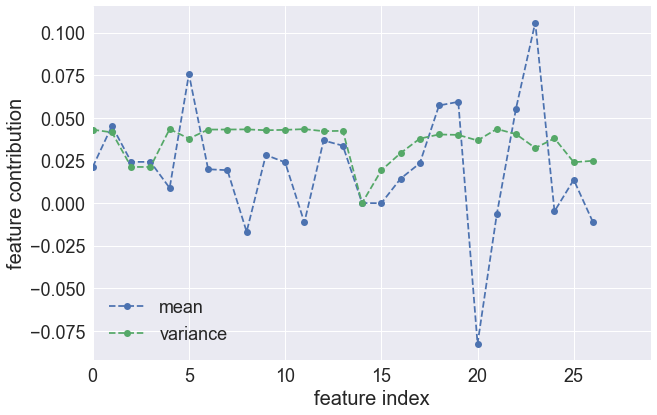

In [66]:
fig = plt.figure(figsize=(10, 6.5))
sn.heatmap(pca.inverse_transform(np.eye(23)), cmap="hot", cbar=False)
plt.ylabel('principal component', fontsize=20);
plt.xlabel('original feature index', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);
plt.show()

pca_inv_data = pca.inverse_transform(np.eye(23))
fig = plt.figure(figsize=(10, 6.5))
plt.plot(pca_inv_data.mean(axis=0), '--o', label = 'mean')
plt.plot(np.square(pca_inv_data.std(axis=0)), '--o', label = 'variance')
plt.legend(loc='lower right')
plt.ylabel('feature contribution', fontsize=20);
plt.xlabel('feature index', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);
plt.xlim([0, 29])
plt.legend(loc='lower left', fontsize=18)
plt.show()
#pd.DataFrame(pca.components_,columns=data_scaled.columns)

# Silhouette for n_clusters for K-Means

For n_clusters = 2 The average silhouette_score is : 0.15186262501
For n_clusters = 3 The average silhouette_score is : 0.116667660264
For n_clusters = 4 The average silhouette_score is : 0.141572695358
For n_clusters = 5 The average silhouette_score is : 0.144952077373
For n_clusters = 6 The average silhouette_score is : 0.128451362622
For n_clusters = 7 The average silhouette_score is : 0.134623325823
For n_clusters = 8 The average silhouette_score is : 0.13432486776
For n_clusters = 9 The average silhouette_score is : 0.144445143976
For n_clusters = 10 The average silhouette_score is : 0.142309670241


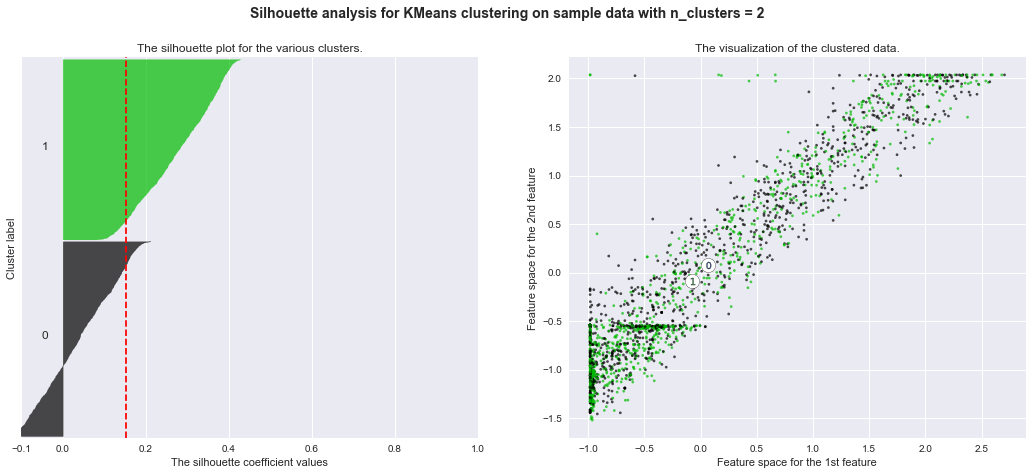

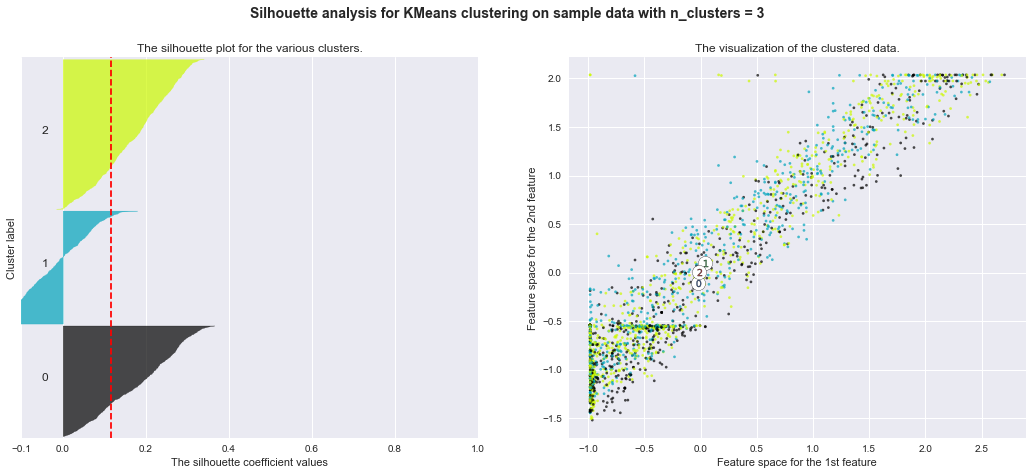

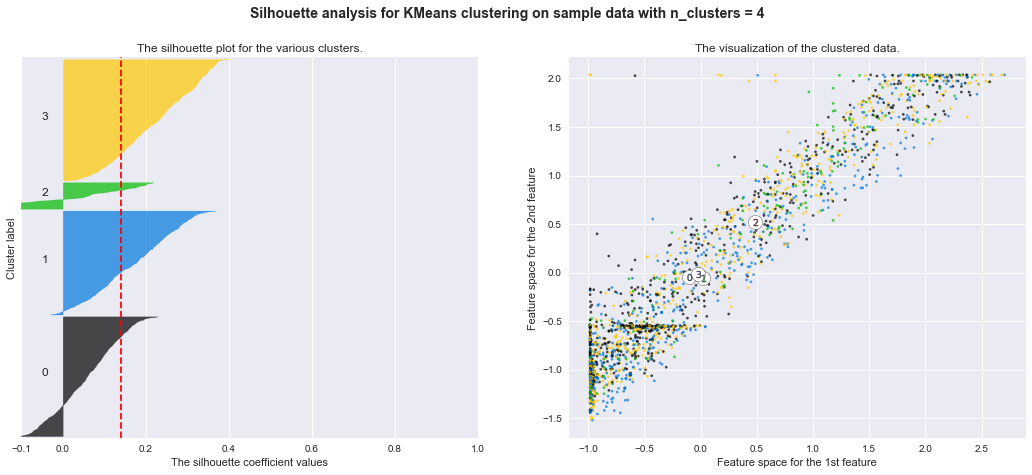

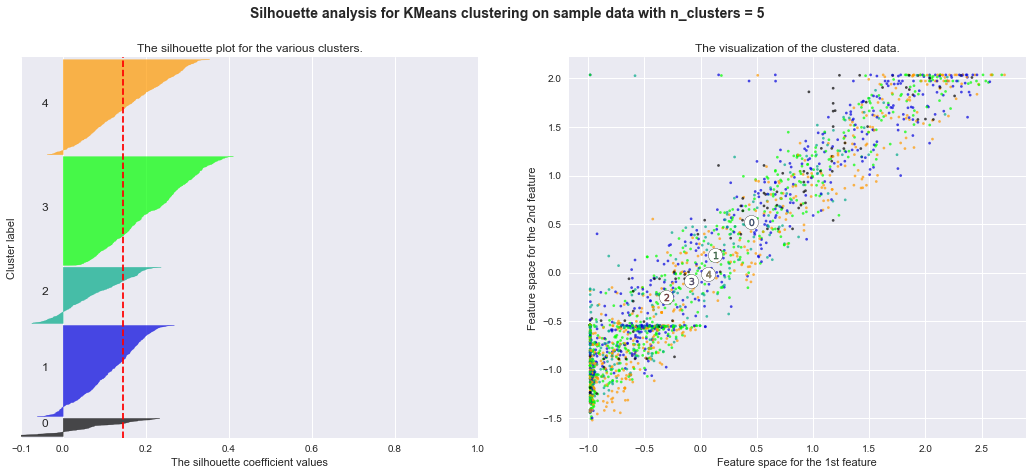

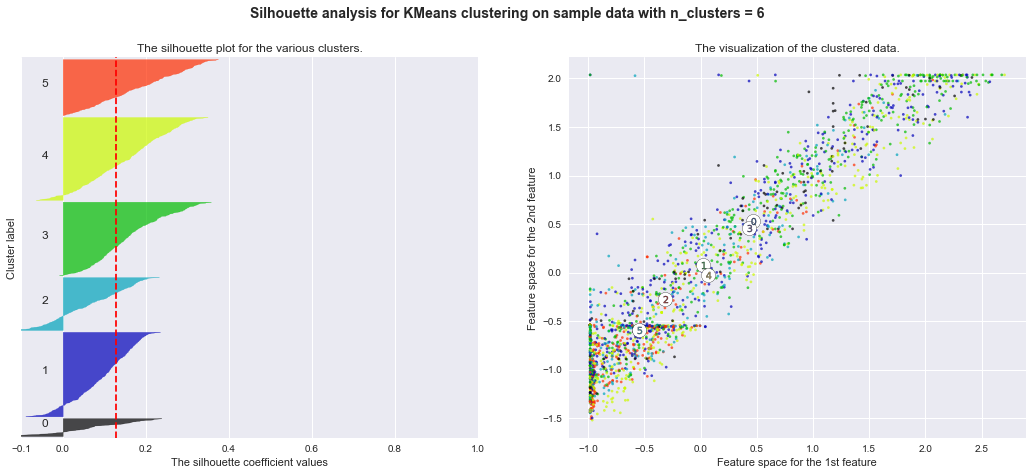

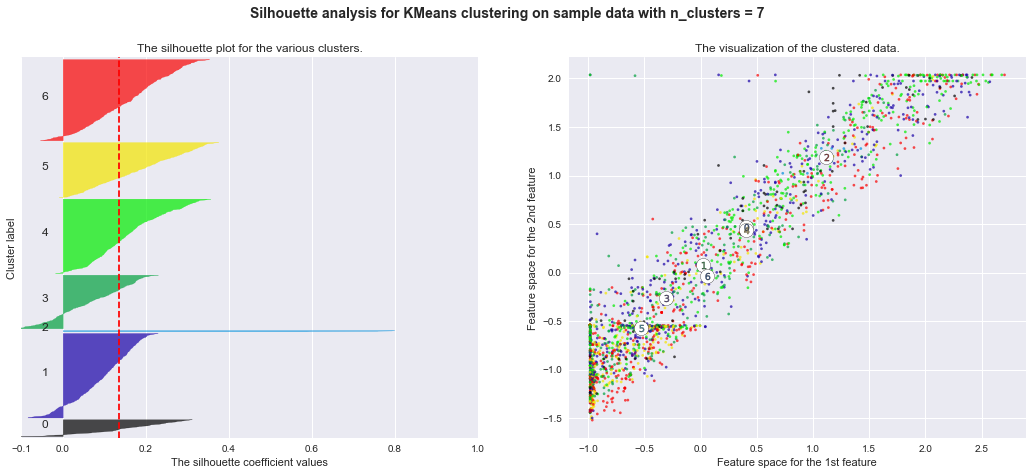

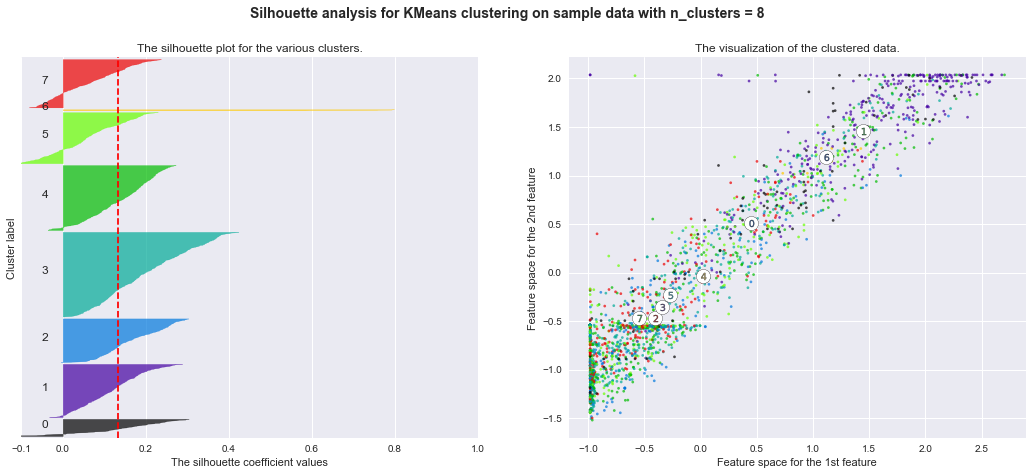

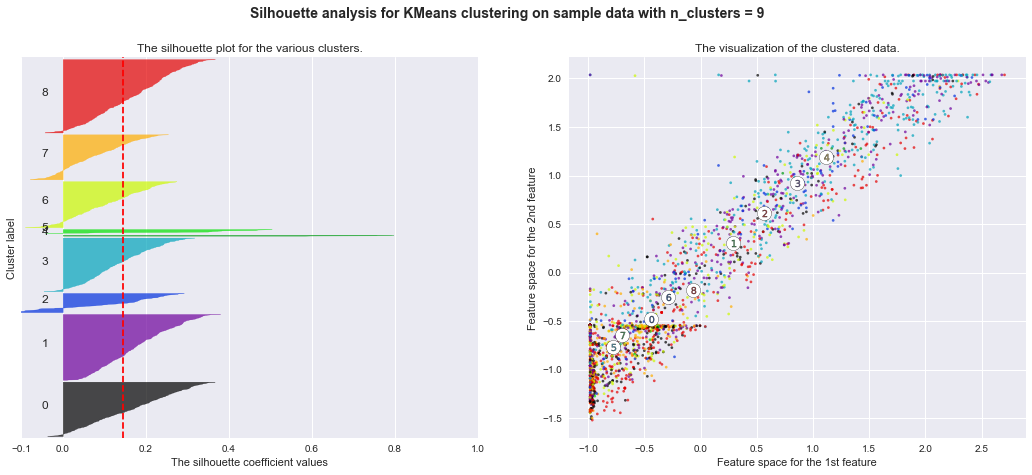

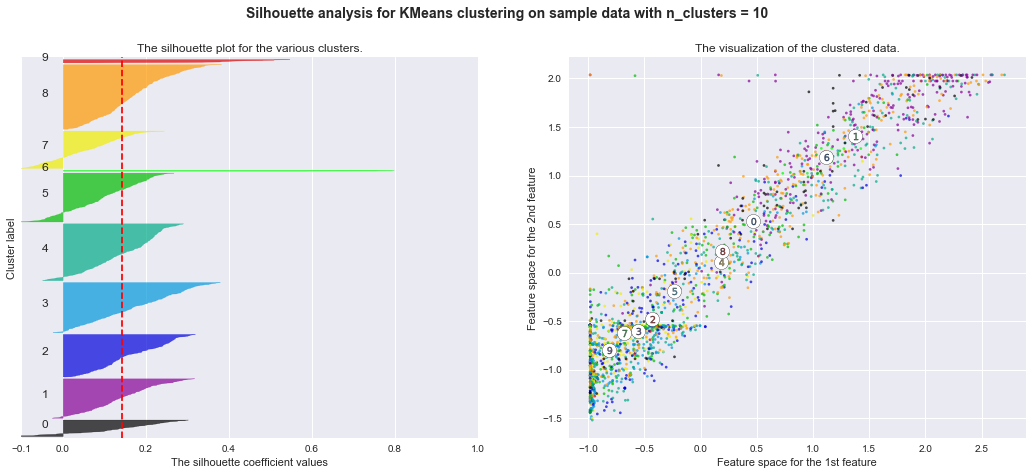

In [29]:


range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# V-Measure for 3-class and 10-class EM/K-Means using PCA at 95% variance

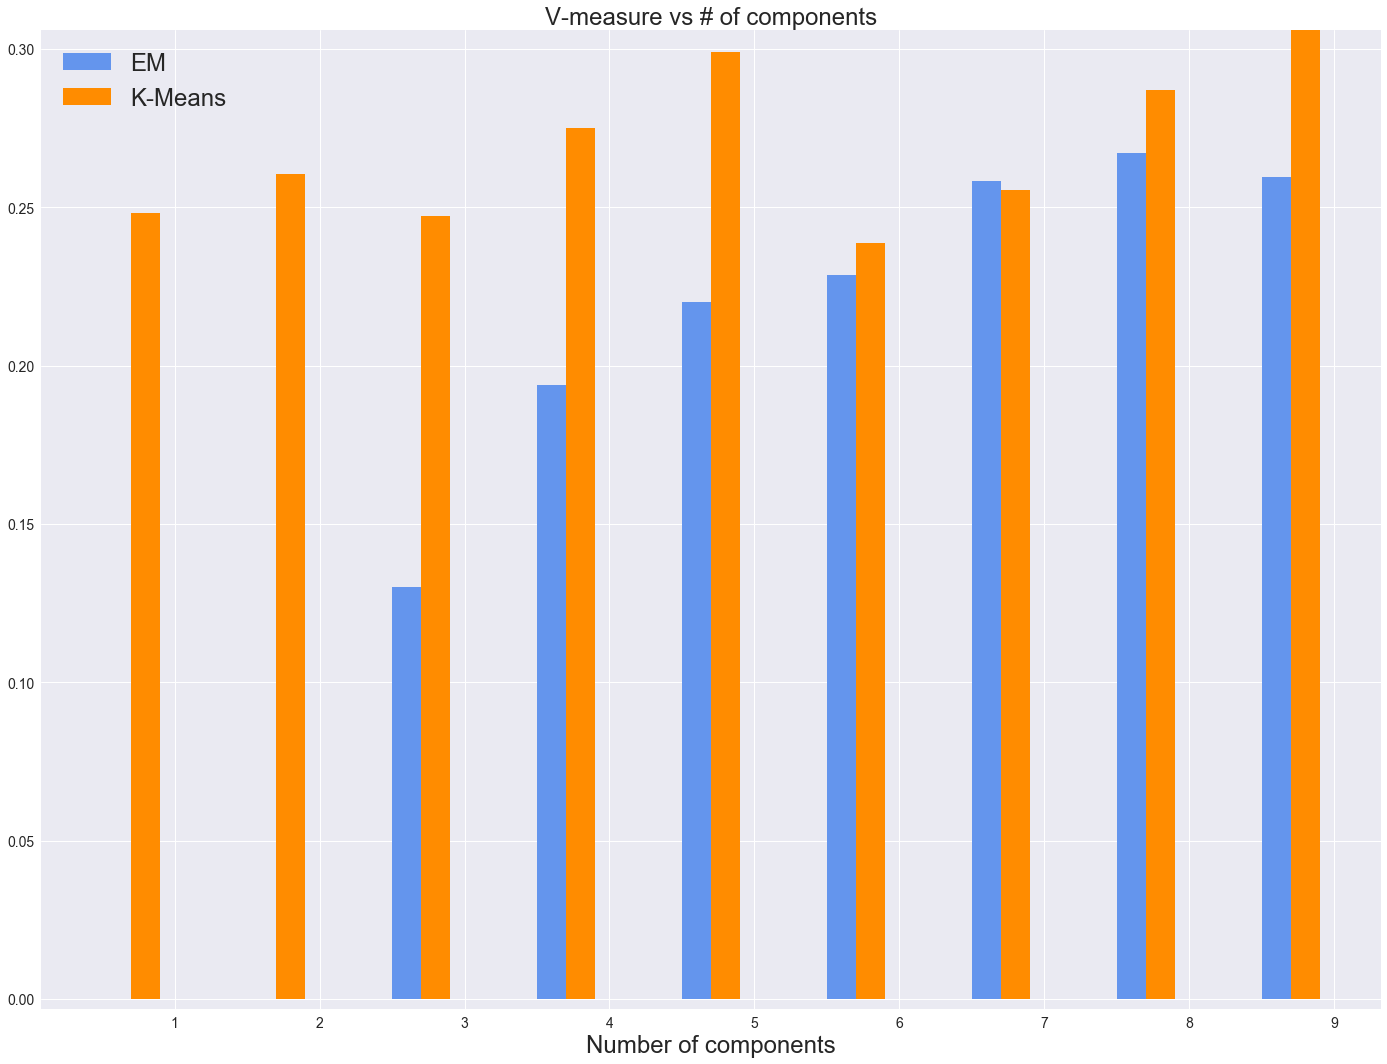

Homogeneity: 0.381
Completeness: 0.132
V-measure: 0.197
Fowlkes-Mallows: 0.385


In [8]:
v_measures = np.array([])
v_measures_em = np.array([])
ars = []
fowlkes = []
n_components_range = range(1,10)
pca = decomposition.PCA(n_components=13)
pca.fit(X)
X_transformed = pca.transform(X)
    
for n in n_components_range:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_transformed)
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full')
    gmm.fit(X_transformed)
    label_cluster_points = gmm.predict(X_transformed)
    v_measures = np.append(v_measures, metrics.v_measure_score(y_class, label_cluster_points))
    v_measures = np.append(v_measures, metrics.v_measure_score(y_class, kmeans.labels_))
    #v_measures_em = np.append(v_measures_em, metrics.v_measure_score(y, label_cluster_points))
    

bars = []
plt.figure(figsize=(24, 18))
spl = plt.subplot(1, 1, 1)
methods = ['EM', 'K-Means']
color_iter = itertools.cycle(['cornflowerblue', 'darkorange'])
for i, (method, color) in enumerate(zip(methods, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, v_measures[i * len(n_components_range): (i + 1) * len(n_components_range)], width=.2, color=color))
plt.xticks(n_components_range, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([v_measures.min() * 1.01 - .01 * v_measures.max(), v_measures.max()])
plt.title('V-measure vs # of components', fontsize=24)
spl.set_xlabel('Number of components', fontsize=24) 
spl.legend([b[0] for b in bars], methods, fontsize=24)
plt.show()
    
#plt.plot(Ns, v_measures)
#plt.plot(Ns, v_measures_em)
#plt.title("V-Measure vs # of clusters", fontsize=16)
#plt.plot(Ns, ars)
#plt.plot(Ns, fowlkes)
#plt.show()

#plt.scatter(
#    X['LB'],X['MSTV'], 
#    c=kmeans.labels_, 
#    cmap='rainbow'
#)  
#plt.show()


print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y, kmeans.labels_))
print("Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(y, kmeans.labels_))

# ICA analysis of components/algorithm based on kurtosis

/home/dlobatog/.anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Best model is parallel 17


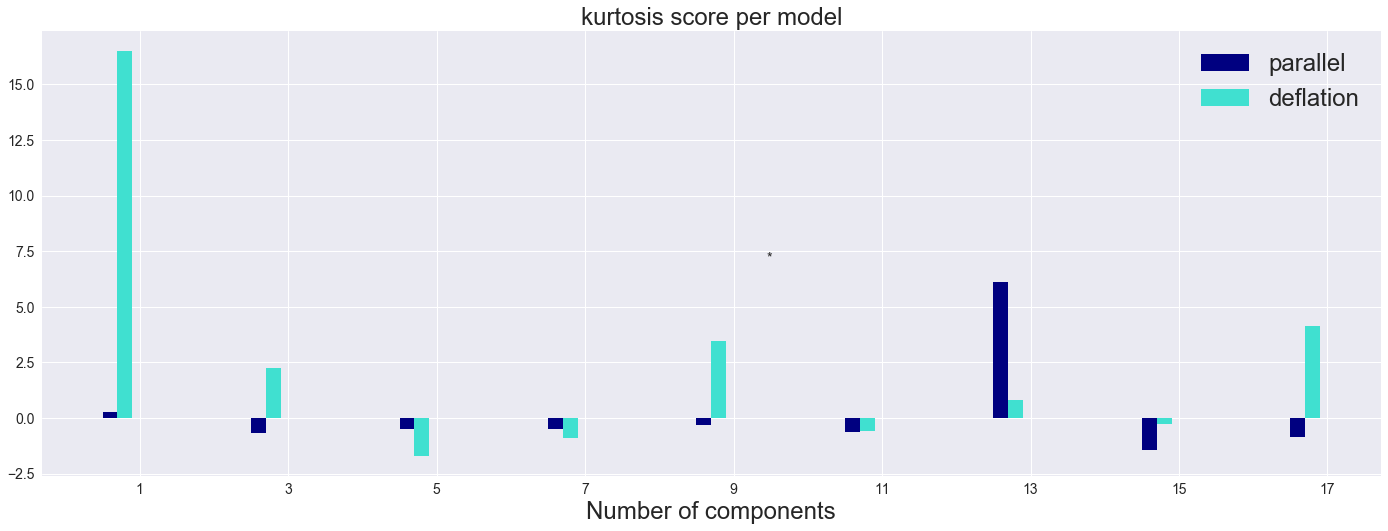

In [6]:
# Generate random sample, two components
from scipy.stats import kurtosis

np.random.seed(0)
C = y

lowest_kurtosis = np.infty
best_n_components = 0
best_algorithm = 0
kurtosis_values = np.array([])
n_components_range = range(1, 19, 2)
algorithms = ['parallel', 'deflation']
for algorithm in algorithms:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        ica = decomposition.FastICA(n_components=n_components, algorithm=algorithm)
        ica.fit(X)
        X_transformed = ica.transform(X)
        kurtosis_values = np.append(kurtosis_values, kurtosis(X_transformed))
        if kurtosis_values[-1] < lowest_kurtosis:
            lowest_kurtosis = kurtosis_values[-1]
            best_gmm = ica
            best_n_components = n_components
            best_algorithm = algorithm

kurtosis_values = np.array(kurtosis_values)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
print("Best model is", best_algorithm, best_n_components)
bars = []

# Plot the kurtosis scores
plt.figure(figsize=(24, 18))
spl = plt.subplot(2, 1, 1)
for i, (algorithm, color) in enumerate(zip(algorithms, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, kurtosis_values[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range, fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([kurtosis_values.min() * 1.01 - .01 * kurtosis_values.max(), kurtosis_values.max()])
plt.title('kurtosis score per model', fontsize=24)
xpos = np.mod(kurtosis_values.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(kurtosis_values.argmin() / len(n_components_range))
plt.text(xpos, kurtosis_values.min() * 0.97 + .03 * kurtosis_values.max(), '*', fontsize=14)
spl.set_xlabel('Number of components', fontsize=24)
spl.legend([b[0] for b in bars], algorithms, fontsize=24)
plt.show()

# V-Measure for ICA and best kurtosis combinations

/home/dlobatog/.anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


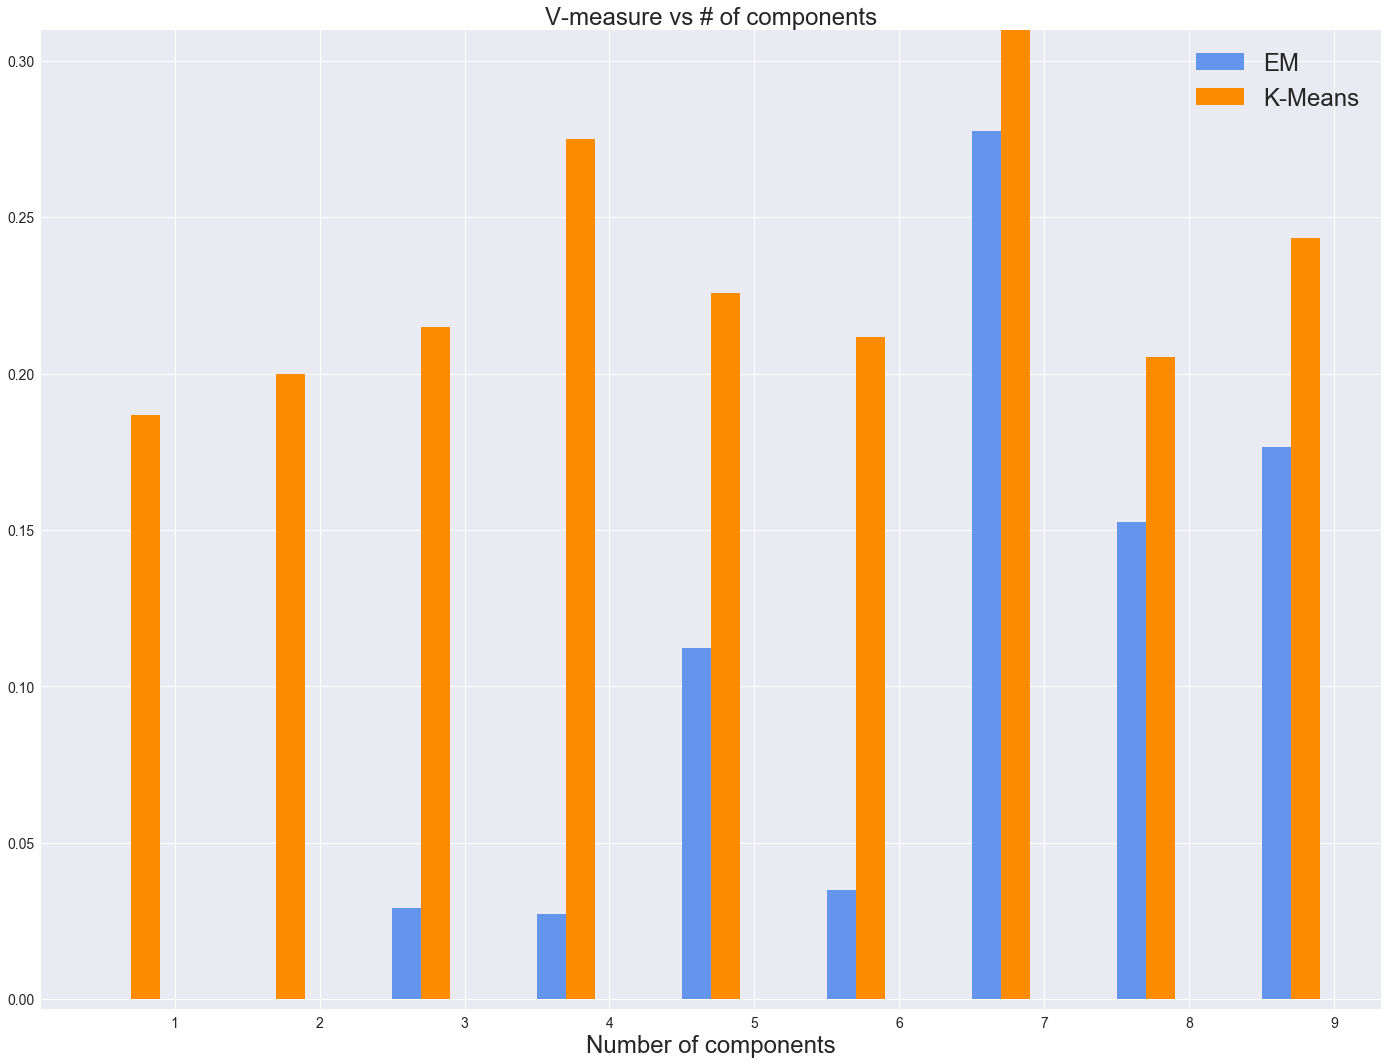

Homogeneity: 0.230
Completeness: 0.084
V-measure: 0.123
Fowlkes-Mallows: 0.355


In [9]:

v_measures = np.array([])
v_measures_em = np.array([])
ars = []
fowlkes = []
n_components_range = range(1,10)
ica = decomposition.FastICA(n_components=13, algorithm='parallel')
ica.fit(X)
X_transformed = ica.transform(X)
    
for n in n_components_range:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_transformed)
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full')
    gmm.fit(X_transformed)
    label_cluster_points = gmm.predict(X_transformed)
    v_measures = np.append(v_measures, metrics.v_measure_score(y_class, label_cluster_points))
    v_measures = np.append(v_measures, metrics.v_measure_score(y_class, kmeans.labels_))
    #v_measures_em = np.append(v_measures_em, metrics.v_measure_score(y, label_cluster_points))
    

bars = []
plt.figure(figsize=(24, 18))
spl = plt.subplot(1, 1, 1)
methods = ['EM', 'K-Means']
color_iter = itertools.cycle(['cornflowerblue', 'darkorange'])
for i, (method, color) in enumerate(zip(methods, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, v_measures[i * len(n_components_range): (i + 1) * len(n_components_range)], width=.2, color=color))
plt.xticks(n_components_range, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([v_measures.min() * 1.01 - .01 * v_measures.max(), v_measures.max()])
plt.title('V-measure vs # of components', fontsize=24)
spl.set_xlabel('Number of components', fontsize=24) 
spl.legend([b[0] for b in bars], methods, fontsize=24)
plt.show()
    
#plt.plot(Ns, v_measures)
#plt.plot(Ns, v_measures_em)
#plt.title("V-Measure vs # of clusters", fontsize=16)
#plt.plot(Ns, ars)
#plt.plot(Ns, fowlkes)
#plt.show()

#plt.scatter(
#    X['LB'],X['MSTV'], 
#    c=kmeans.labels_, 
#    cmap='rainbow'
#)  
#plt.show()


print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y, kmeans.labels_))
print("Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(y, kmeans.labels_))

# Random Projections - Johnson Lindenstrauss 

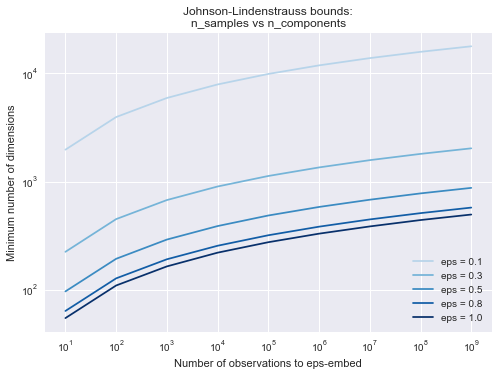

Dimensions needed 6567


In [13]:
# range of admissible distortions
eps_range = np.linspace(0.1, 0.99, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))

# range of number of samples (observation) to embed
n_samples_range = np.logspace(1, 9, 9)

plt.figure()
for eps, color in zip(eps_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components, color=color)

plt.legend(["eps = %0.1f" % eps for eps in eps_range], loc="lower right")
plt.xlabel("Number of observations to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")
plt.show()

print("Dimensions needed", johnson_lindenstrauss_min_dim(len(X)))

# Random projections - Vmeasure

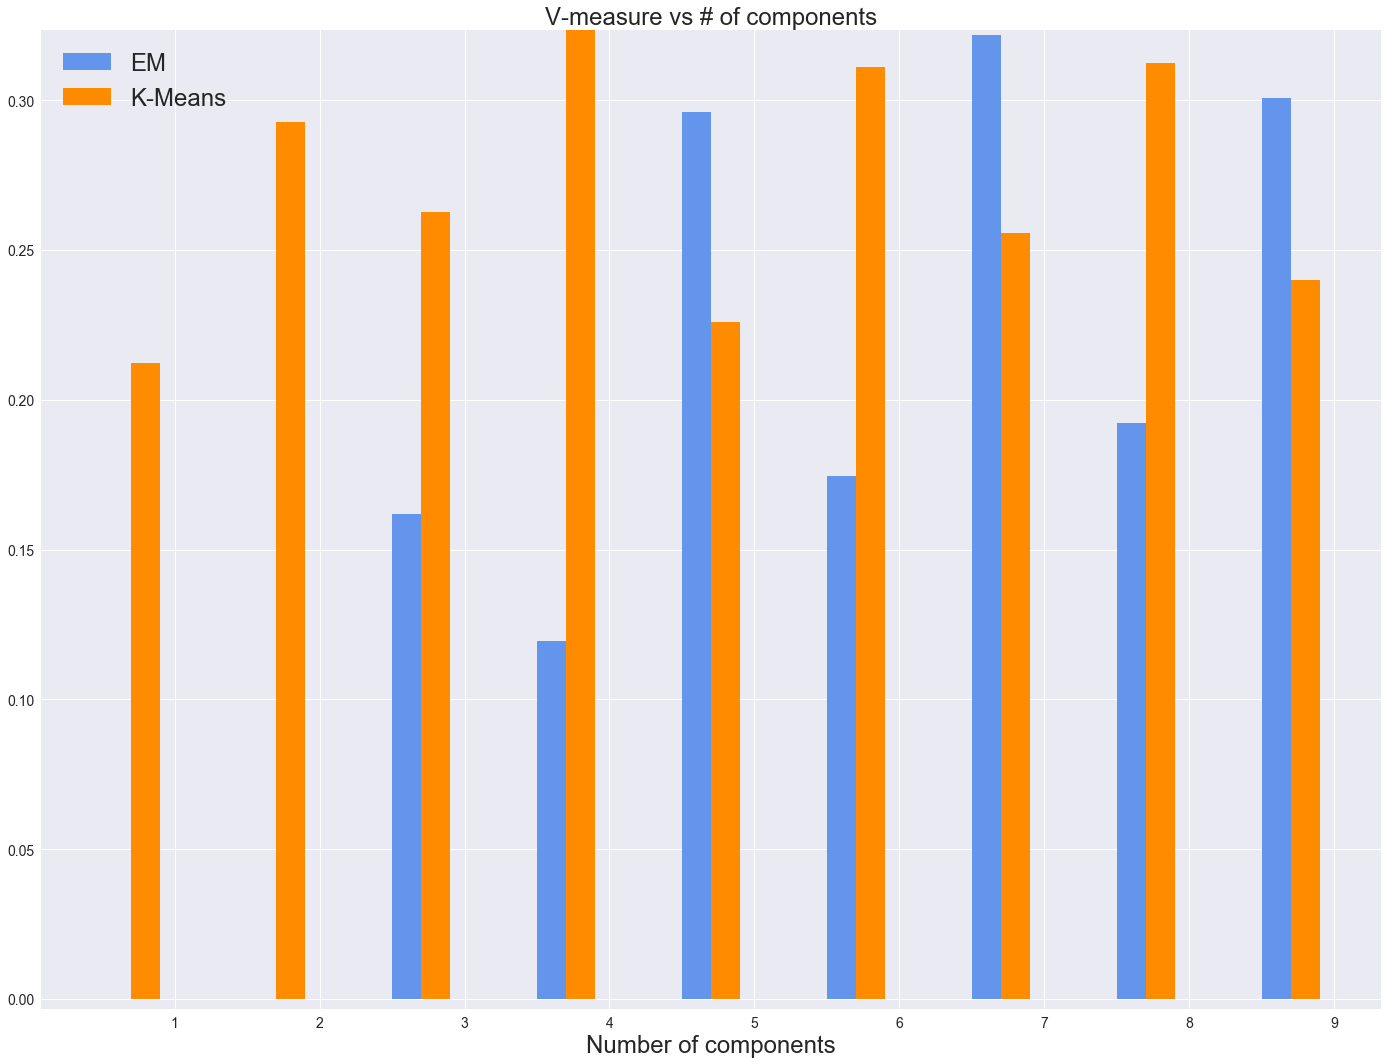

In [21]:
from sklearn.random_projection import SparseRandomProjection

v_measures = np.array([])
v_measures_em = np.array([])
ars = []
fowlkes = []
n_components_range = range(1,10)
transformer = SparseRandomProjection(n_components=10)
X_transformed = transformer.fit_transform(X)
    
for n in n_components_range:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_transformed)
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full')
    gmm.fit(X_transformed)
    label_cluster_points = gmm.predict(X_transformed)
    v_measures = np.append(v_measures, metrics.v_measure_score(y_class, label_cluster_points))
    v_measures = np.append(v_measures, metrics.v_measure_score(y_class, kmeans.labels_))
    #v_measures_em = np.append(v_measures_em, metrics.v_measure_score(y, label_cluster_points))
    

bars = []
plt.figure(figsize=(24, 18))
spl = plt.subplot(1, 1, 1)
methods = ['EM', 'K-Means']
color_iter = itertools.cycle(['cornflowerblue', 'darkorange'])
for i, (method, color) in enumerate(zip(methods, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, v_measures[i * len(n_components_range): (i + 1) * len(n_components_range)], width=.2, color=color))
plt.xticks(n_components_range, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([v_measures.min() * 1.01 - .01 * v_measures.max(), v_measures.max()])
plt.title('V-measure vs # of components', fontsize=24)
spl.set_xlabel('Number of components', fontsize=24) 
spl.legend([b[0] for b in bars], methods, fontsize=24)
plt.show()
    

# Backward Feature Elimination

[False False  True  True False False  True  True False  True False False
  True  True False False False False False False  True False False  True
 False False False]
[ 4  3  1  1  8 18  1  1 14  1  9 17  1  1 19 10  2  5 15 16  1 13  7  1 11
 12  6]


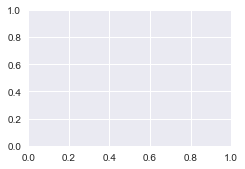

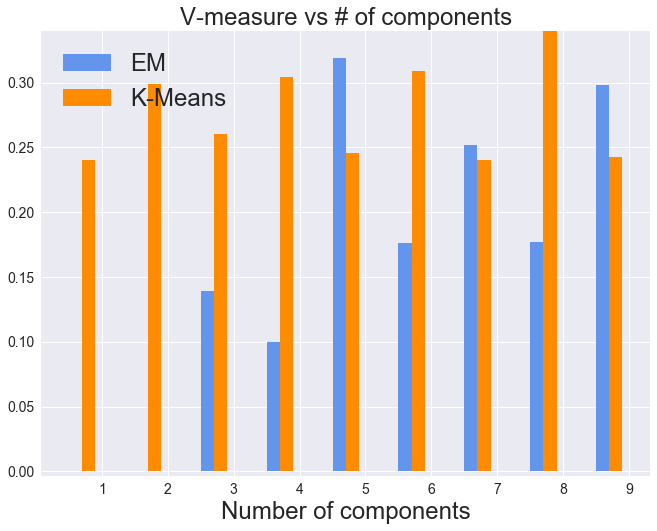

In [3]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
n_components_range = range(1,10)
spl = plt.subplot(2, 2, 1)
for n in n_components_range:
    selector = RFE(estimator, n, step=1)
    selector = selector.fit(X, y)
print(selector.support_) 
print(selector.ranking_)

v_measures = np.array([])
v_measures_em = np.array([])

X_transformed = selector.fit_transform(X, y)
    
for n in n_components_range:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_transformed)
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full')
    gmm.fit(X_transformed)
    label_cluster_points = gmm.predict(X_transformed)
    v_measures = np.append(v_measures, metrics.v_measure_score(y_class, label_cluster_points))
    v_measures = np.append(v_measures, metrics.v_measure_score(y_class, kmeans.labels_))
    #v_measures_em = np.append(v_measures_em, metrics.v_measure_score(y, label_cluster_points))
    

bars = []
plt.figure(figsize=(24, 18))
spl = plt.subplot(2, 2, 1)
methods = ['EM', 'K-Means']
color_iter = itertools.cycle(['cornflowerblue', 'darkorange'])
for i, (method, color) in enumerate(zip(methods, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, v_measures[i * len(n_components_range): (i + 1) * len(n_components_range)], width=.2, color=color))
plt.xticks(n_components_range, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([v_measures.min() * 1.01 - .01 * v_measures.max(), v_measures.max()])
plt.title('V-measure vs # of components', fontsize=24)
spl.set_xlabel('Number of components', fontsize=24) 
spl.legend([b[0] for b in bars], methods, fontsize=24)
plt.figure(figsize=(24, 18))

plt.show()
    

# Accuracy and time in NN original vs NN after dimensionality reduction

In [16]:
## NN model
X_numpy = X
accuracies = []
y_preds = []
X = data_scaled
n_features = len(X.columns)    

pca = decomposition.PCA(n_components=13)
pca.fit(X)
X_transformed_PCA = pca.transform(X)

ica = decomposition.FastICA(n_components=13, algorithm='parallel')
ica.fit(X)
X_transformed_ICA = ica.transform(X)

transformer = SparseRandomProjection(n_components=6)
X_transformed_RP_six = transformer.fit_transform(X)

transformer = SparseRandomProjection(n_components=7)
X_transformed_RP_seven = transformer.fit_transform(X)

transformer = SparseRandomProjection(n_components=8)
X_transformed_RP_eight = transformer.fit_transform(X)

estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
X_transformed_RFE = selector.fit_transform(X, y)

def confusion_matrix_plot(confusion_matrix):
    classNames = ['A', 'B', 'C', 'D', 'SH', 'AD', 'DE', 'LD', 'FS', 'SUSP']
    plt.clf()
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return(TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC)
    

def scale_data(X_train, X_test):
    scaler = StandardScaler()
    # Fit only to the training data
    scaler.fit(X_train)
    # Now apply the transformations to the data:
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

def compute_accuracy_nn(X):
    number_of_folds = 3

    k_fold = KFold(number_of_folds)
    k_folds = k_fold.split(X, y)

    X_train_folds, y_train_folds, X_test_folds, y_test_folds = [], [], [], []
    for k, (train, test) in enumerate(k_fold.split(X, y)):
        X_train, X_test = scale_data(X.iloc[train], X.iloc[test])
        X_train_folds.append(X_train)
        y_train_folds.append(y.iloc[train])
        X_test_folds.append(X_test)
        y_test_folds.append(y.iloc[test])

    for k in range(len(y_test_folds)):
        X_train, X_test = X_train_folds[k], X_test_folds[k]
        y_train, y_test = y_train_folds[k], y_test_folds[k]
        mlp = MLPClassifier(hidden_layer_sizes=(n_features,n_features,n_features),max_iter=500)
        mlp.fit(X_train,y_train)
        y_pred = mlp.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        y_preds.append(y_pred)
        print(k, "fold: ", accuracy)

    print("Accuracy: Mean", np.mean(accuracies), "Stddev", np.std(accuracies))
    cm = confusion_matrix(y_test_folds[2], y_preds[2])
    print(confusion_matrix(y_test_folds[2], y_preds[2]))
    confusion_matrix_plot(cm)

    param_distributions = {'hidden_layer_sizes': stats.randint(1,300), 'alpha': stats.uniform(0.0001,0.1) }
    rand_search = RandomizedSearchCV(MLPClassifier(), param_distributions=param_distributions,
                                     n_iter = 20, n_jobs = 4, cv = 3, scoring=make_scorer(accuracy_score))
    rand_search.fit(X, y)
    cv_results = rand_search.cv_results_
    print(rand_search.best_estimator_)
    print(rand_search.best_score_)
    return(rand_search)

/home/dlobatog/.anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [24]:
print("NN original")
nn_original = compute_accuracy_nn(X)
print("PCA")
nn_pca = compute_accuracy_nn(pd.DataFrame(X_transformed_PCA))
print("ICA")
nn_ica = compute_accuracy_nn(pd.DataFrame(X_transformed_ICA))
print("RP 6")
nn_rp_six = compute_accuracy_nn(pd.DataFrame(X_transformed_RP_six))
print("RP 7")
nn_rp_seven = compute_accuracy_nn(pd.DataFrame(X_transformed_RP_seven))
print("RP 8")
nn_rp_eight = compute_accuracy_nn(pd.DataFrame(X_transformed_RP_eight))
print("RFE")
nn_rfe = compute_accuracy_nn(pd.DataFrame(X_transformed_RFE))

NN original
0 fold:  0.785613540197
1 fold:  0.940761636107
2 fold:  0.793785310734
Accuracy: Mean 0.828895502804 Stddev 0.0740454364681
[[484  90  16]
 [ 16  12   0]
 [ 17  19  54]]
MLPClassifier(activation='relu', alpha=0.040118156255063805,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=83, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
0.824082784572
PCA
0 fold:  0.782792665726
1 fold:  0.92101551481
2 fold:  0.858757062147
Accuracy: Mean 0.831705826295 Stddev 0.0727439642444
[[484  90  16]
 [ 16  12   0]
 [ 17  19  54]]
MLPClassifier(activation='relu', alpha=0.035529514095095041,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=11, lear

0.00928597172867


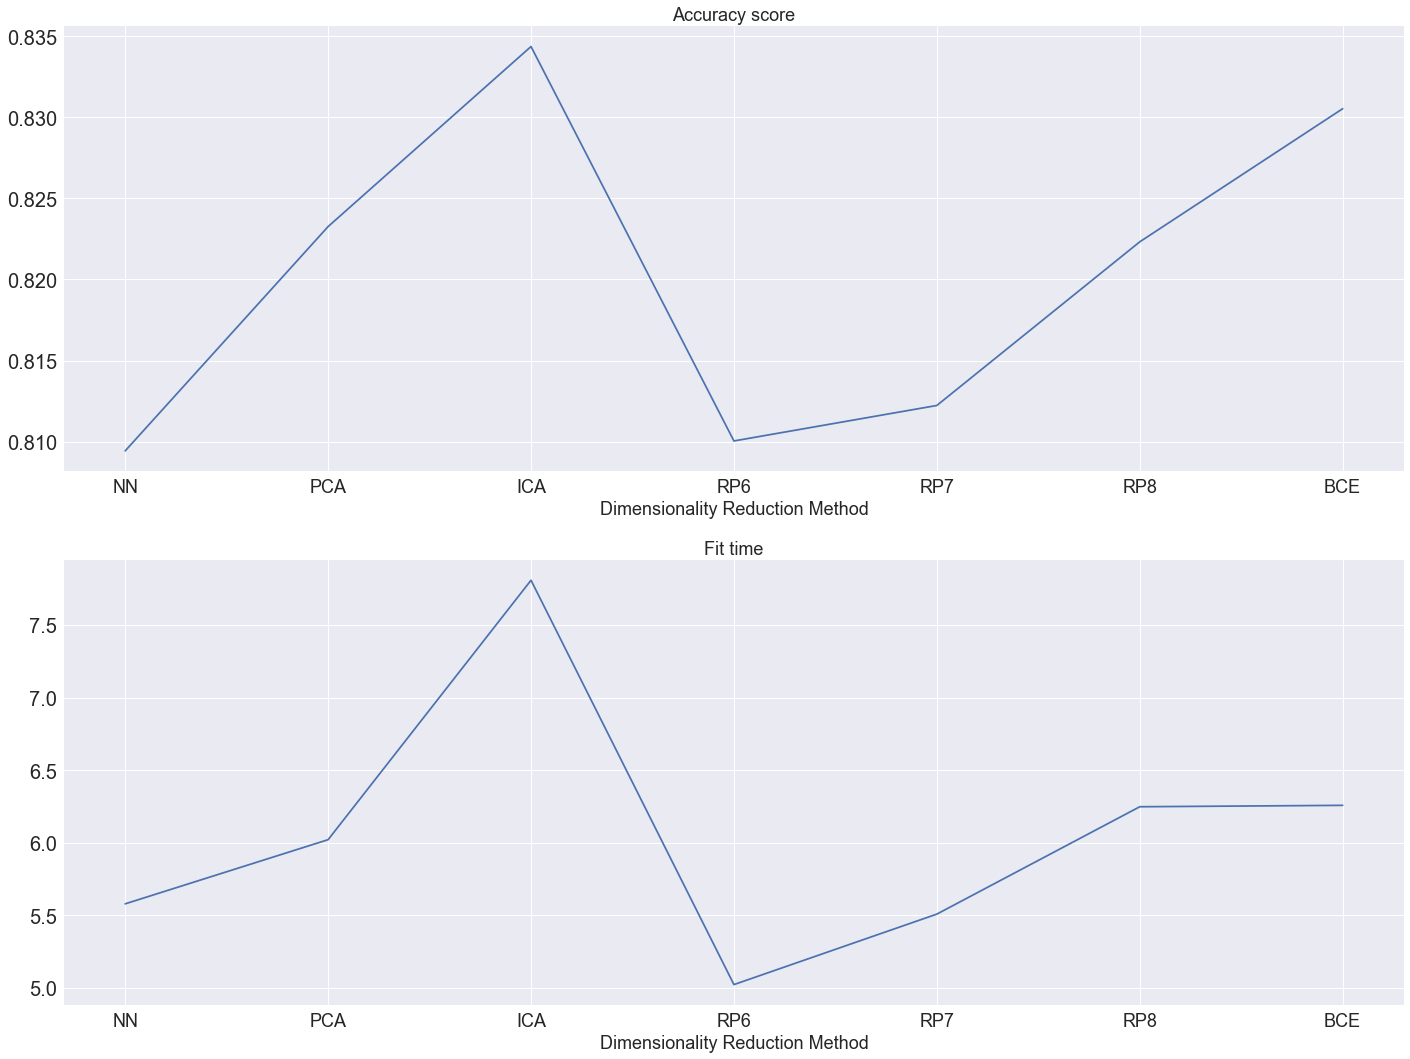

In [80]:
fit_time = [nn_original.cv_results_['mean_fit_time'].mean()]
test_score = [nn_original.cv_results_['mean_test_score'].mean()]
fit_time.append(nn_pca.cv_results_['mean_fit_time'].mean())
test_score.append(nn_pca.cv_results_['mean_test_score'].mean())
fit_time.append(nn_ica.cv_results_['mean_fit_time'].mean())
test_score.append(nn_ica.cv_results_['mean_test_score'].mean())
fit_time.append(nn_rp_six.cv_results_['mean_fit_time'].mean())
test_score.append(nn_rp_six.cv_results_['mean_test_score'].mean())
fit_time.append(nn_rp_seven.cv_results_['mean_fit_time'].mean())
test_score.append(nn_rp_seven.cv_results_['mean_test_score'].mean())
fit_time.append(nn_rp_eight.cv_results_['mean_fit_time'].mean())
test_score.append(nn_rp_eight.cv_results_['mean_test_score'].mean())
fit_time.append(nn_rfe.cv_results_['mean_fit_time'].mean())
test_score.append(nn_rfe.cv_results_['mean_test_score'].mean())
types = ['NN', 'PCA', 'ICA', 'RP6', 'RP7', 'RP8', 'BCE']

print(np.std(test_score))

plt.figure(figsize=(24, 18))
spl = plt.subplot(2, 1, 1)
plt.plot(test_score)
plt.title('Accuracy score', fontsize=18)
plt.yticks(fontsize=20)
plt.xticks(range(len(types)), types, fontsize=18)
spl.set_xlabel('Dimensionality Reduction Method', fontsize=18)
spl = plt.subplot(2, 1, 2)
plt.plot(fit_time)
plt.title('Fit time', fontsize=18)
plt.yticks(fontsize=20)
plt.xticks(range(len(types)), types, fontsize=18)
spl.set_xlabel('Dimensionality Reduction Method', fontsize=18)
plt.show()

# Feeding clusters to the NN

In [84]:
#print("NN original")
#nn_original = compute_accuracy_nn(X_transformed)
def create_clusters(X, k_clusters, em_components): 
    kmeans = KMeans(n_clusters=k_clusters)
    k_clusters = kmeans.fit_transform(X)
    gmm = mixture.GaussianMixture(n_components=em_components, covariance_type='full')
    gmm.fit(X)
    em_clusters = gmm.predict(X)
    return(k_clusters, em_clusters)

PCA_clusters_k, PCA_clusters_em = create_clusters(X_transformed_PCA, 5, 8)
ICA_clusters_k, ICA_clusters_em = create_clusters(X_transformed_ICA, 3, 8)
RP_six_clusters_k, RP_six_clusters_em = create_clusters(X_transformed_RP_six, 5, 6)
RP_seven_clusters_k, RP_seven_clusters_em = create_clusters(X_transformed_RP_seven, 5, 6)
RP_eight_clusters_k, RP_eight_clusters_em = create_clusters(X_transformed_RP_eight, 5, 6)
RFE_clusters_k, RFE_clusters_em = create_clusters(X_transformed_RFE, 8, 4)

print("PCA")
nn_pca_k = compute_accuracy_nn(pd.DataFrame(PCA_clusters_k))
nn_pca_em = compute_accuracy_nn(pd.DataFrame(PCA_clusters_em))
print("ICA")
nn_ica_k = compute_accuracy_nn(pd.DataFrame(ICA_clusters_k))
nn_ica_em = compute_accuracy_nn(pd.DataFrame(ICA_clusters_em))
print("RP 6")
nn_rp_six_k = compute_accuracy_nn(pd.DataFrame(RP_six_clusters_k))
nn_rp_six_em = compute_accuracy_nn(pd.DataFrame(RP_six_clusters_em))
print("RP 7")
nn_rp_seven_k = compute_accuracy_nn(pd.DataFrame(RP_seven_clusters_k))
nn_rp_seven_em = compute_accuracy_nn(pd.DataFrame(RP_seven_clusters_em))
print("RP 8")
nn_rp_eight_k = compute_accuracy_nn(pd.DataFrame(RP_eight_clusters_k))
nn_rp_eight_em = compute_accuracy_nn(pd.DataFrame(RP_eight_clusters_em))
print("RFE")
nn_rfe_k = compute_accuracy_nn(pd.DataFrame(RFE_clusters_k))
nn_rfe_em = compute_accuracy_nn(pd.DataFrame(RFE_clusters_em))

PCA
0 fold:  0.703808180536
1 fold:  0.898448519041
2 fold:  0.800847457627
Accuracy: Mean 0.827022578506 Stddev 0.0726388712978
[[484  90  16]
 [ 16  12   0]
 [ 17  19  54]]
MLPClassifier(activation='relu', alpha=0.013726073265535443,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=36, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
0.843367826905
0 fold:  0.630465444288
1 fold:  0.83215796897
2 fold:  0.851694915254
Accuracy: Mean 0.823548632527 Stddev 0.0758464427409
[[484  90  16]
 [ 16  12   0]
 [ 17  19  54]]
MLPClassifier(activation='relu', alpha=0.032641543417683674,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=278, learning_rate='

0.0275823472816


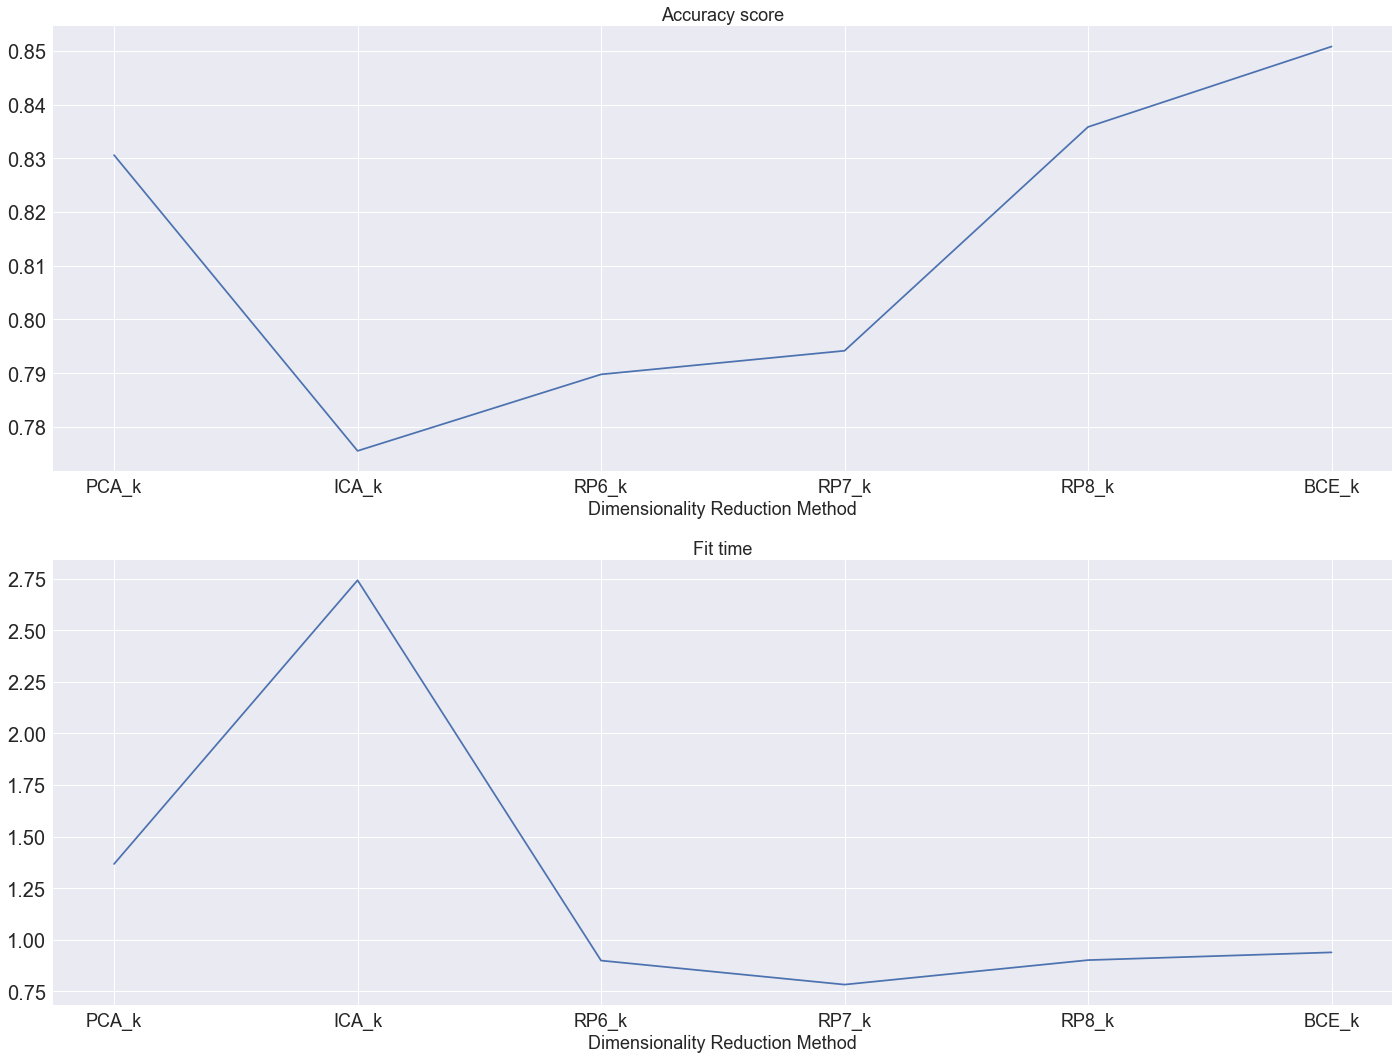

In [88]:
fit_time = []
test_score = []
fit_time.append(nn_pca_k.cv_results_['mean_fit_time'].mean())
test_score.append(nn_pca_k.cv_results_['mean_test_score'].mean())
fit_time.append(nn_ica_k.cv_results_['mean_fit_time'].mean())
test_score.append(nn_ica_k.cv_results_['mean_test_score'].mean())
fit_time.append(nn_rp_six_k.cv_results_['mean_fit_time'].mean())
test_score.append(nn_rp_six_k.cv_results_['mean_test_score'].mean())
fit_time.append(nn_rp_seven_k.cv_results_['mean_fit_time'].mean())
test_score.append(nn_rp_seven_k.cv_results_['mean_test_score'].mean())
fit_time.append(nn_rp_eight_k.cv_results_['mean_fit_time'].mean())
test_score.append(nn_rp_eight_k.cv_results_['mean_test_score'].mean())
fit_time.append(nn_rfe_k.cv_results_['mean_fit_time'].mean())
test_score.append(nn_rfe_k.cv_results_['mean_test_score'].mean())
types = ['PCA_k', 'ICA_k', 'RP6_k', 'RP7_k', 'RP8_k', 'BCE_k']

print(np.std(test_score))

plt.figure(figsize=(24, 18))
spl = plt.subplot(2, 1, 1)
plt.plot(test_score)
plt.title('Accuracy score', fontsize=18)
plt.yticks(fontsize=20)
plt.xticks(range(len(types)), types, fontsize=18)
spl.set_xlabel('Dimensionality Reduction Method', fontsize=18)
spl = plt.subplot(2, 1, 2)
plt.plot(fit_time)
plt.title('Fit time', fontsize=18)
plt.yticks(fontsize=20)
plt.xticks(range(len(types)), types, fontsize=18)
spl.set_xlabel('Dimensionality Reduction Method', fontsize=18)
plt.show()